In [1]:
import requests
import pandas as pd

import json

In [2]:
exportacoes_mundo_2023 = pd.read_excel('./dados/comex/Exportação  Mundo 2023 NCM.xlsx')
exportacoes_usa_2023 = pd.read_excel('./dados/comex/Exportação USA 2023 NCM.xlsx.xlsx')


In [3]:
exportacoes_mundo_2023['cod_ncm'] = exportacoes_mundo_2023['Código NCM'].astype(str).str.zfill(8)
exportacoes_usa_2023['cod_ncm'] = exportacoes_usa_2023['Código NCM'].astype(str).str.zfill(8)

In [4]:
exportacoes_mundo_2023.head(2)

,Código NCM,Descrição NCM,2023 - Valor US$ FOB,cod_ncm
0,12019000,"Soja, mesmo triturada, exceto para semeadura",53238560791,12019000
1,27090010,Óleos brutos de petróleo,42611078672,27090010


In [5]:
#Taxa média de câmbio em 2023 - compra
taxa_cambio = 5.39  # Exemplo de taxa média de câmbio em 2023
exportacoes_mundo_2023['R$ FOB Mundo'] = exportacoes_mundo_2023['2023 - Valor US$ FOB'] * taxa_cambio
exportacoes_usa_2023['R$ FOB USA'] = exportacoes_usa_2023['2023 - Valor US$ FOB'] * taxa_cambio

## Agregar por SH6

In [6]:
exportacoes_mundo_2023['SH6'] = exportacoes_mundo_2023['cod_ncm'].str[0:6]
exportacoes_usa_2023['SH6'] = exportacoes_usa_2023['cod_ncm'].str[0:6]

#Agregar os valores por SH6
exportacoes_mundo_2023 = exportacoes_mundo_2023.groupby('SH6')[['R$ FOB Mundo']].sum()
    

In [7]:
exportacoes_usa_2023 = exportacoes_usa_2023.groupby('SH6')[['R$ FOB USA']].sum()    

In [8]:
exportacoes = exportacoes_mundo_2023.merge(exportacoes_usa_2023, on='SH6', how='left').fillna(0)

In [9]:
exportacoes['participacao_usa'] = exportacoes['R$ FOB USA'] / (exportacoes['R$ FOB Mundo'])

In [10]:
exportacoes.head(2)

,R$ FOB Mundo,R$ FOB USA,participacao_usa
SH6,,,
010121,40075081.20,29427610.52,0.734312
010129,21803972.96,15256136.28,0.699695


In [11]:
exportacoes_mundo_2023.head(2)

,R$ FOB Mundo
SH6,
010121,40075081.20
010129,21803972.96


## Mapeamento ISIC e CNAE

In [12]:
ncm_isic = pd.read_csv('./dados/comex/NCM_ISIC (1).csv',sep=';',dtype={'CO_ISIC_CLASSE': str, 'NO_ISIC_CLASSE': str}    )
ncm = pd.read_csv('./dados/comex/NCM (2).csv',sep=';',dtype={'CO_SH6': str, 'CO_ISIC_CLASSE': str})

In [13]:
mapeamento_isic = pd.read_excel('./dados/mapeamento/mapeamento_isic_cnae.xlsx', dtype=str).drop(columns=['Unnamed: 3','Observações'])

In [14]:
mapeamento_isic.head(2)

,código ISIC,denominação ISIC,código CNAE,denominação CNAE
0,A,"AGRICULTURA, GANADERÍA, SILVICULTURA Y PESCA",A,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES..."
1,01,"AGRICULTURA, GANADERÍA, CAZA Y ACTIVIDADES DE ...",01,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS"


In [15]:

#Remmover linhas em que o código ISIC tem comprimento menor que 4
mapeamento_isic = mapeamento_isic[mapeamento_isic['código ISIC'].str.len() == 3]
mapeamento_isic.tail()

,código ISIC,denominação ISIC,código CNAE,denominação CNAE
1171,960,Otras actividades de servicios personales,96.0,Outras atividades de serviços pessoais
1178,970,Actividades de los hogares como empleadores de...,97.0,Serviços domésticos
1181,981,Actividades no diferenciadas de los hogares co...,NaN,NaN
1183,982,Actividades no diferenciadas de los hogares co...,NaN,NaN
1187,990,Actividades de organizaciones y órganos extrat...,99.0,Organismos internacionais e outras instituiçõe...


In [16]:
mapeamento_isic = mapeamento_isic.dropna()

In [17]:
lista_isic_usa_3d  =exportacoes_usa_2023.reset_index().merge(ncm, left_on='SH6', right_on='CO_SH6', how='left')['CO_ISIC_CLASSE'].str[0:3].drop_duplicates()

In [19]:
mapeamento_isic['CNAE2d'] = mapeamento_isic['código CNAE'].str[0:2]
mapeamento_isic['ISIC2d'] = mapeamento_isic['código ISIC'].str[0:2]

In [20]:
mapeamento_isic.groupby('ISIC2d')[['CNAE2d']].nunique().sort_values(by='CNAE2d', ascending=False).head(10)

,CNAE2d
ISIC2d,
19,2
22,2
16,2
20,2
88,2
70,2
58,2
08,1
07,1


In [21]:
mapeamento_isic.query('ISIC2d.isin(["58","70","88"])')

,código ISIC,denominação ISIC,código CNAE,denominação CNAE,CNAE2d,ISIC2d
822,581,Edición de libros y publicaciones periódicas y...,58.1,"Edição de livros, jornais, revistas e outras a...",58,58
823,581,Edición de libros y publicaciones periódicas y...,58.2,"Edição integrada à impressão de livros, jornai...",58,58
834,582,Edición de programas informáticos,62.0,Atividades dos serviços de tecnologia da infor...,62,58
955,701,Actividades de oficinas principales,64.6,Atividades de sociedades de participação,64,70
956,701,Actividades de oficinas principales,70.1,Sedes de empresas e unidades administrativas l...,70,70
960,702,Actividades de consultoría de gestión,70.2,Atividades de consultoria em gestão empresarial,70,70
1117,881,Actividades de asistencia social sin alojamien...,88.0,Serviços de assistência social sem alojamento,88,88
1119,889,Otras actividades de aistencia social sin aloj...,85.1,Educação infantil e ensino fundamental,85,88
1120,889,Otros servicios sociales sin alojamiento n.c.p.,88.0,Serviços de assistência social sem alojamento,88,88


In [22]:
mapeamento_isic.query('`CNAE2d`.isin(["15"])')

,código ISIC,denominação ISIC,código CNAE,denominação CNAE,CNAE2d,ISIC2d
213,151,Curtido y adobo de cueros; fabricación de male...,15.1,Curtimento e outras preparações de couro,15,15
214,151,Curtido y adobo de cueros; fabricación de male...,15.2,Fabricação de artigos para viagem e de artefat...,15,15
218,152,Fabricación de calzado,15.3,Fabricação de calçados,15,15
219,152,Fabricación de calzado,15.4,"Fabricação de partes para calçados, de qualque...",15,15
229,162,"Fabricación de productos de madera, corcho, pa...",15.4,"Fabricação de partes para calçados, de qualque...",15,16
315,221,Fabricación de productos de caucho,15.4,"Fabricação de partes para calçados, de qualque...",15,22
321,222,Fabricación de productos de plástico,15.4,"Fabricação de partes para calçados, de qualque...",15,22


Há produtos exportados para os EUA que não estão mapeados no NCM_ISIC, como por exemplo:

In [24]:
mapeamento_isic.query('`código ISIC`.isin(["2220","2219","1629","2011"])')

,código ISIC,denominação ISIC,código CNAE,denominação CNAE,CNAE2d,ISIC2d


## Decidiu-se por usar os dois primeiros dígitos do ISIC como aproximação da CNAE

In [26]:
exportacoes = exportacoes.query('`R$ FOB USA` > 0')

In [27]:
exportacoes = ncm[['CO_SH6','CO_ISIC_CLASSE']].drop_duplicates().merge(exportacoes, left_on='CO_SH6', right_on='SH6', how='inner')

In [28]:
exportacoes['CNAE2s'] = exportacoes['CO_ISIC_CLASSE'].str[0:2]

In [29]:
exportacoes.head(2)

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,CNAE2s
0,490110,5811,6996257.73,701988.21,0.100338,58
1,490191,5811,2892376.41,73713.64,0.025485,58


## Carregar dados da PIA Empresa

In [97]:
url_pia_empresa = 'https://apisidra.ibge.gov.br/values/t/1842/n1/all/v/824,825/p/last%201/c12762/all'

data = requests.get(url_pia_empresa)
data = data.json()
pia_empresa_rlv = pd.DataFrame(data, columns=data[0])


In [98]:
pia_empresa_rlv.columns = pia_empresa_rlv.iloc[0]
pia_empresa_rlv = pia_empresa_rlv[1:]


In [99]:
pia_empresa_rlv.head(2)


,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Variável (Código),Variável,Ano (Código),Ano,Classificação Nacional de Atividades Econômicas (CNAE 2.0) (Código),Classificação Nacional de Atividades Econômicas (CNAE 2.0)
1,1,Brasil,40,Mil Reais,6353568639,1,Brasil,824,Total da receita líquida de vendas,2023,2023,117897,Total
2,1,Brasil,40,Mil Reais,456258347,1,Brasil,824,Total da receita líquida de vendas,2023,2023,116880,B Indústrias extrativas


In [100]:
mapeamento_isic

,código ISIC,denominação ISIC,código CNAE,denominação CNAE,CNAE2d,ISIC2d,cnae
2,011,Cultivo de plantas no perenes,01.1,Produção de lavouras temporárias,01,01,011
3,011,Cultivo de plantas no perenes,01.2,Horticultura e floricultura,01,01,012
4,011,Cultivo de plantas no perenes,01.3,Produção de lavouras permanentes,01,01,013
5,011,Cultivo de plantas no perenes,01.4,Produção de sementes e mudas certificadas,01,01,014
25,012,Cultivo de plantas perennes,01.1,Produção de lavouras temporárias,01,01,011
...,...,...,...,...,...,...,...
1161,951,Reparación de ordenadores y equipo de comunica...,95.1,Reparação e manutenção de equipamentos de info...,95,95,951
1164,952,Reparación de efectos personales y enseres dom...,95.2,Reparação e manutenção de objetos e equipament...,95,95,952
1171,960,Otras actividades de servicios personales,96.0,Outras atividades de serviços pessoais,96,96,960
1178,970,Actividades de los hogares como empleadores de...,97.0,Serviços domésticos,97,97,970


In [101]:
##Filtrar apenas registros cujos valores da coluna 'Classificação Nacional de Atividades Econômicas (CNAE 2.0)' siga o padrão \d{2}\.\d{1} 
pia_empresa_rlv_2d = pia_empresa_rlv[pia_empresa_rlv['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str.match(r'^\d{2} ')]
pia_empresa_rlv_3d = pia_empresa_rlv[pia_empresa_rlv['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str.match(r'^\d{2}\.\d{1} ')]    

In [102]:
pia_empresa_rlv_3d.head(2)

,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Variável (Código),Variável,Ano (Código),Ano,Classificação Nacional de Atividades Econômicas (CNAE 2.0) (Código),Classificação Nacional de Atividades Econômicas (CNAE 2.0)
4,1,Brasil,40,Mil Reais,1941673,1,Brasil,824,Total da receita líquida de vendas,2023,2023,116882,05.0 Extração de carvão mineral
6,1,Brasil,40,Mil Reais,163281926,1,Brasil,824,Total da receita líquida de vendas,2023,2023,116885,06.0 Extração de petróleo e gás natural


In [103]:
pia_empresa_rlv_2d['cnae'] = pia_empresa_rlv['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[0:2].str.replace('.','', regex=False)
pia_empresa_rlv_2d['cnae_descricao'] = pia_empresa_rlv['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[3:]

pia_empresa_rlv_2d.head(2)



/tmp/ipykernel_5306/1836566463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pia_empresa_rlv_2d['cnae'] = pia_empresa_rlv['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[0:2].str.replace('.','', regex=False)
/tmp/ipykernel_5306/1836566463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pia_empresa_rlv_2d['cnae_descricao'] = pia_empresa_rlv['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[3:]


,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Variável (Código),Variável,Ano (Código),Ano,Classificação Nacional de Atividades Econômicas (CNAE 2.0) (Código),Classificação Nacional de Atividades Econômicas (CNAE 2.0),cnae,cnae_descricao
3,1,Brasil,40,Mil Reais,1941673,1,Brasil,824,Total da receita líquida de vendas,2023,2023,116881,05 Extração de carvão mineral,05,Extração de carvão mineral
5,1,Brasil,40,Mil Reais,163281926,1,Brasil,824,Total da receita líquida de vendas,2023,2023,116884,06 Extração de petróleo e gás natural,06,Extração de petróleo e gás natural


In [104]:
pia_empresa_rlv_3d['cnae'] = pia_empresa_rlv_3d['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[0:4].str.replace('.','', regex=False)
pia_empresa_rlv_3d['cnae_descricao'] = pia_empresa_rlv_3d['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[5:]

/tmp/ipykernel_5306/1737546974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pia_empresa_rlv_3d['cnae'] = pia_empresa_rlv_3d['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[0:4].str.replace('.','', regex=False)
/tmp/ipykernel_5306/1737546974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pia_empresa_rlv_3d['cnae_descricao'] = pia_empresa_rlv_3d['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[5:]


In [105]:
pia_empresa_rlv = pd.concat([pia_empresa_rlv_2d[['Variável','cnae','cnae_descricao','Valor']], pia_empresa_rlv_3d[['Variável','cnae','cnae_descricao','Valor']]], ignore_index=True)

In [106]:
pia_empresa_rlv.tail()

,Variável,cnae,cnae_descricao,Valor
275,Receita líquida de vendas de produtos e serviç...,324,Fabricação de brinquedos e jogos recreativos,3297487
276,Receita líquida de vendas de produtos e serviç...,325,Fabricação de instrumentos e materiais para us...,20777571
277,Receita líquida de vendas de produtos e serviç...,329,Fabricação de produtos diversos,15396002
278,Receita líquida de vendas de produtos e serviç...,331,Manutenção e reparação de máquinas e equipamentos,50921841
279,Receita líquida de vendas de produtos e serviç...,332,Instalação de máquinas e equipamentos,6735735


In [107]:
#Linhas em que o valor da coluna 'Valor' não pode ser convertido para float, trocar por -1
pia_empresa_rlv['Valor'] = pd.to_numeric(pia_empresa_rlv['Valor'], errors='coerce').fillna(-1)
pia_empresa_rlv['Valor'] = pia_empresa_rlv['Valor']*1000
#Fazer o pivot transformando a coluna 'Variável' em colunas e preenchendo com os valores da coluna 'Valor'
pia_empresa_rlv = pia_empresa_rlv.pivot_table(index=['cnae','cnae_descricao'], columns='Variável', values='Valor')
pia_empresa_rlv.reset_index(inplace=True)

In [108]:
mapeamento_isic['cnae'] = mapeamento_isic['código CNAE'].str.replace('.','', regex=False)

In [54]:
exportacoes_pia = exportacoes.copy()

In [55]:
lista_codigos_isic_mapeados_multiplas_cnae_3d = pia_empresa_rlv_3d[['cnae']].drop_duplicates().merge(mapeamento_isic, on='cnae', how='left').groupby('código ISIC')[['código CNAE']].nunique().reset_index().query("`código CNAE` > 1")['código ISIC'].unique().tolist()

In [56]:
#criar uma coluna 'cnae' em exportacoes_pia e fazer com que seu valor  seja igual aos 2 dígitos da coluna CO_ISIC_CLASSE, caso os 3 primeiros dígitos do código isic classe fizerem parte de lista_codigos_isic_mapeados_multiplas_cnae_3d
# caso contrário, usar None
exportacoes_pia['cnae'] = exportacoes_pia['CO_ISIC_CLASSE'].str[0:2].where(
    exportacoes_pia['CO_ISIC_CLASSE'].str[0:3].isin(lista_codigos_isic_mapeados_multiplas_cnae_3d),
    None
)

In [57]:
mapeamento_isic.head()

,código ISIC,denominação ISIC,código CNAE,denominação CNAE,CNAE2d,ISIC2d,cnae
2,011,Cultivo de plantas no perenes,01.1,Produção de lavouras temporárias,01,01,011
3,011,Cultivo de plantas no perenes,01.2,Horticultura e floricultura,01,01,012
4,011,Cultivo de plantas no perenes,01.3,Produção de lavouras permanentes,01,01,013
5,011,Cultivo de plantas no perenes,01.4,Produção de sementes e mudas certificadas,01,01,014
25,012,Cultivo de plantas perennes,01.1,Produção de lavouras temporárias,01,01,011


In [58]:
mapeamento_isic

,código ISIC,denominação ISIC,código CNAE,denominação CNAE,CNAE2d,ISIC2d,cnae
2,011,Cultivo de plantas no perenes,01.1,Produção de lavouras temporárias,01,01,011
3,011,Cultivo de plantas no perenes,01.2,Horticultura e floricultura,01,01,012
4,011,Cultivo de plantas no perenes,01.3,Produção de lavouras permanentes,01,01,013
5,011,Cultivo de plantas no perenes,01.4,Produção de sementes e mudas certificadas,01,01,014
25,012,Cultivo de plantas perennes,01.1,Produção de lavouras temporárias,01,01,011
...,...,...,...,...,...,...,...
1161,951,Reparación de ordenadores y equipo de comunica...,95.1,Reparação e manutenção de equipamentos de info...,95,95,951
1164,952,Reparación de efectos personales y enseres dom...,95.2,Reparação e manutenção de objetos e equipament...,95,95,952
1171,960,Otras actividades de servicios personales,96.0,Outras atividades de serviços pessoais,96,96,960
1178,970,Actividades de los hogares como empleadores de...,97.0,Serviços domésticos,97,97,970


In [59]:
#Nos campos None em cnae, usar o valor da coluna CO_ISIC_CLASSE e mapear os 3 primeiros dígitos para o código CNAE usando como mapeamento o mapeamento_isic
mapeamento_isic_unico = mapeamento_isic.drop_duplicates(subset='código ISIC')

exportacoes_pia['cnae'] = exportacoes_pia['cnae'].fillna(
    exportacoes_pia['CO_ISIC_CLASSE'].str[0:3].map(
        mapeamento_isic_unico.set_index('código ISIC')['cnae']
    )
)

In [60]:
exportacoes_pia.head()

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,CNAE2s,cnae
0,490110,5811,6.996258e+06,701988.21,0.100338,58,581
1,490191,5811,2.892376e+06,73713.64,0.025485,58,581
2,490199,5811,1.819830e+08,19922588.07,0.109475,58,581
3,521029,1312,4.218591e+05,9055.20,0.021465,13,13
4,521032,1312,7.247394e+05,7702.31,0.010628,13,13


In [61]:
exportacoes_pia.head()

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,CNAE2s,cnae
0,490110,5811,6.996258e+06,701988.21,0.100338,58,581
1,490191,5811,2.892376e+06,73713.64,0.025485,58,581
2,490199,5811,1.819830e+08,19922588.07,0.109475,58,581
3,521029,1312,4.218591e+05,9055.20,0.021465,13,13
4,521032,1312,7.247394e+05,7702.31,0.010628,13,13


In [62]:
exportacoes_pia = exportacoes_pia.merge(pia_empresa_rlv, on='cnae', how='inner')

In [67]:
exportacoes_pia.head()

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,CNAE2s,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas
0,521029,1312,4.218591e+05,9055.20,0.021465,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10
1,521032,1312,7.247394e+05,7702.31,0.010628,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10
2,521039,1312,2.658725e+05,15604.05,0.058690,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10
3,521049,1312,1.742285e+06,36204.63,0.020780,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10
4,640411,1520,4.041184e+08,2587388.65,0.006403,15,15,Preparação de couros e fabricação de artefatos...,5.268440e+10,5.349885e+10


In [65]:
#Criar uma coluna de 'Intensidade Tecnloógica' de acordo com a classificação de intensidade tecnológica da OCDE, mapeada por ISIC, onde a os primeiros dígitos ISIC (2 ou 3 ) podem ser mapeados de acordo com a tabela ISIC x Intensidade Tecnológica é:
# Alta Intensidade Tecnológica: 303, 21, 26,72, 582
# Média Alta Intensidade Tecnológica: 252, 325, 28, 20, 27, 302, 304, 309,62-63
# Média Intensidade Tecnológica: 22, 301, 32 ( com exceção de 325),23, 24, 33
# Média Baixa Intensidade Tecnológica: 10-12,13, 14, 15, 25 ( menos 252),16, 18 19, 31
# Baixa Intensidade Tecnológica: Demais
#Considere que o código ISIC tabela de mapeamento pode ter 2 ou 3 dígitos, que devem corresponder aos primeiros 2 ou 3 dígitos do código ISIC da coluna CO_ISIC_CLASSE, ou seja,
#mapeie inicialmente os códigos com 3 dígitos e em seguida os códigos com 2 dígitos, caso não tenha sido mapeado ainda.
mapeamento_3d = {
    '303': 'Alta Intensidade Tecnológica',
    '582': 'Alta Intensidade Tecnológica',

    '302': 'Média Alta Intensidade Tecnológica',
    '252': 'Média Alta Intensidade Tecnológica',
    '304': 'Média Alta Intensidade Tecnológica',
    '325': 'Média Alta Intensidade Tecnológica',
    '309': 'Média Alta Intensidade Tecnológica',

    '301': 'Média Intensidade Tecnológica',
    
    '581':'Média Baixa Intensidade Tecnológica'
}


# Mapear códigos de 2 dígitos
mapeamento_2d = {
    '21': 'Alta Intensidade Tecnológica',
    '26': 'Alta Intensidade Tecnológica',
    '72': 'Alta Intensidade Tecnológica',

    '29': 'Média Alta Intensidade Tecnológica',
    '28': 'Média Alta Intensidade Tecnológica',
    '20': 'Média Alta Intensidade Tecnológica',
    '27': 'Média Alta Intensidade Tecnológica',
    '62': 'Média Alta Intensidade Tecnológica',
    '63': 'Média Alta Intensidade Tecnológica',

    '22': 'Média Intensidade Tecnológica',
    '32': 'Média Intensidade Tecnológica',
    '23': 'Média Intensidade Tecnológica',
    '24': 'Média Intensidade Tecnológica',
    '25': 'Média Intensidade Tecnológica',
    '33': 'Média Intensidade Tecnológica',

    '10': 'Média Baixa Intensidade Tecnológica',
    '11': 'Média Baixa Intensidade Tecnológica',
    '12': 'Média Baixa Intensidade Tecnológica',
    '13': 'Média Baixa Intensidade Tecnológica',
    '14': 'Média Baixa Intensidade Tecnológica',
    '15': 'Média Baixa Intensidade Tecnológica',
    '16': 'Média Baixa Intensidade Tecnológica',
    '17': 'Média Baixa Intensidade Tecnológica',
    '18': 'Média Baixa Intensidade Tecnológica',
    '19': 'Média Baixa Intensidade Tecnológica',
    '31': 'Média Baixa Intensidade Tecnológica',
    #69 a 75 Média Baixa Intensidade Tecnológica
    '69': 'Média Baixa Intensidade Tecnológica',
    '70': 'Média Baixa Intensidade Tecnológica',
    '71': 'Média Baixa Intensidade Tecnológica',
    '73': 'Média Baixa Intensidade Tecnológica',
    '74': 'Média Baixa Intensidade Tecnológica',
    '75': 'Média Baixa Intensidade Tecnológica',
    '61' : 'Média Baixa Intensidade Tecnológica',
    #05 a 09 Média Baixa Intensidade Tecnológica
    '05': 'Média Baixa Intensidade Tecnológica',
    '06': 'Média Baixa Intensidade Tecnológica',
    '07': 'Média Baixa Intensidade Tecnológica',
    '08': 'Média Baixa Intensidade Tecnológica',
    '09': 'Média Baixa Intensidade Tecnológica'

}



In [70]:
# Aplicar mapeamento primeiro por 3 dígitos, depois por 2 dígitos
exportacoes_pia['Intensidade Tecnológica'] = exportacoes_pia['CO_ISIC_CLASSE'].str[0:3].map(mapeamento_3d)

# Para valores não mapeados (NaN), tentar mapear por 2 dígitos
mask_nao_mapeado = exportacoes_pia['Intensidade Tecnológica'].isna()
exportacoes_pia.loc[mask_nao_mapeado, 'Intensidade Tecnológica'] = exportacoes_pia.loc[mask_nao_mapeado, 'CO_ISIC_CLASSE'].str[0:2].map(mapeamento_2d)

# Exceção: 252 deve ser removido de '25' (que já foi mapeado como Média Alta)
#mask_252 = exportacao_pia['CO_ISIC_CLASSE'].str.startswith('252')
#exportacao_pia.loc[mask_252, 'Intensidade Tecnológica'] = 'Baixa Intensidade Tecnológica'

# Para códigos não mapeados, classificar como 'Baixa Intensidade Tecnológica'
exportacoes_pia['Intensidade Tecnológica'] = exportacoes_pia['Intensidade Tecnológica'].fillna('Baixa Intensidade Tecnológica')

In [73]:
exportacoes.shape

(3455, 6)

In [75]:
exportacoes_pia.shape

(3222, 11)

In [76]:
exportacoes_pia.to_excel('./Outputs/final/exportacao_pia_intensidade.xlsx', index=False)

In [77]:
exportacoes_pia.head(2)

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,CNAE2s,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas,Intensidade Tecnológica
0,521029,1312,421859.13,9055.20,0.021465,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica
1,521032,1312,724739.40,7702.31,0.010628,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica


In [78]:
tarifas = pd.read_excel('./dados/comex/NCM_SH6_Tarifas.xlsx')

In [80]:
tarifas.tail()

,SH6,Instrumento,Tarifa,Articles of Civil Aircraft only
6612,400122,Ordem 30/07,Tarifa de 50%,NaN
6613,400129,Ordem 30/07,Tarifa de 50%,NaN
6614,392113,Ordem 30/07,Tarifa de 50%,NaN
6615,481014,Ordem 30/07,Tarifa de 50%,NaN
6616,392112,Ordem 30/07,Tarifa de 50%,NaN


In [128]:
tarifas['Articles of Civil Aircraft only'].fillna('',inplace=True)

In [129]:
tarifas['Articles of Civil Aircraft only'].value_counts()

Articles of Civil Aircraft only
     6329
*     288
Name: count, dtype: int64

In [130]:
tarifas.head(2)

,SH6,Instrumento,Tarifa,Articles of Civil Aircraft only
0,490110,Ordem 30/07,Tarifa de 50%,
1,490191,Ordem 30/07,Tarifa de 50%,


In [133]:
tarifas['SH6'] = tarifas['SH6'].astype(str).str.zfill(6)

In [134]:
tarifas.head(2)

,SH6,Instrumento,Tarifa,Articles of Civil Aircraft only
0,490110,Ordem 30/07,Tarifa de 50%,
1,490191,Ordem 30/07,Tarifa de 50%,


In [ ]:
exportacoes_pia.merge()

CO_SH6                                                           object
CO_ISIC_CLASSE                                                   object
R$ FOB Mundo                                                    float64
R$ FOB USA                                                      float64
participacao_usa                                                float64
CNAE2s                                                           object
cnae                                                             object
cnae_descricao                                                   object
Receita líquida de vendas de produtos e serviços industriais    float64
Total da receita líquida de vendas                              float64
Intensidade Tecnológica                                          object
dtype: object

In [131]:
exportacoes_pia.shape

(3222, 11)

In [137]:
exportacoes_pia_tarifas = exportacoes_pia.merge(tarifas.rename(columns={"SH6":"CO_SH6"}),on='CO_SH6',how='left')

In [145]:
exportacoes_pia_tarifas.head()

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,CNAE2s,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas,Intensidade Tecnológica,Instrumento,Tarifa,Articles of Civil Aircraft only
0,521029,1312,4.218591e+05,9055.20,0.021465,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
1,521032,1312,7.247394e+05,7702.31,0.010628,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
2,521039,1312,2.658725e+05,15604.05,0.058690,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
3,521049,1312,1.742285e+06,36204.63,0.020780,13,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
4,640411,1520,4.041184e+08,2587388.65,0.006403,15,15,Preparação de couros e fabricação de artefatos...,5.268440e+10,5.349885e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,


In [154]:
exportacoes_pia_tarifas.columns

Index(['CO_SH6', 'CO_ISIC_CLASSE', 'R$ FOB Mundo', 'R$ FOB USA',
       'participacao_usa', 'CNAE2s', 'cnae', 'cnae_descricao',
       'Receita líquida de vendas de produtos e serviços industriais',
       'Total da receita líquida de vendas', 'Intensidade Tecnológica',
       'Instrumento', 'Tarifa', 'Articles of Civil Aircraft only'],
      dtype='object')

=== ANÁLISE GERAL - TODOS OS SETORES ===


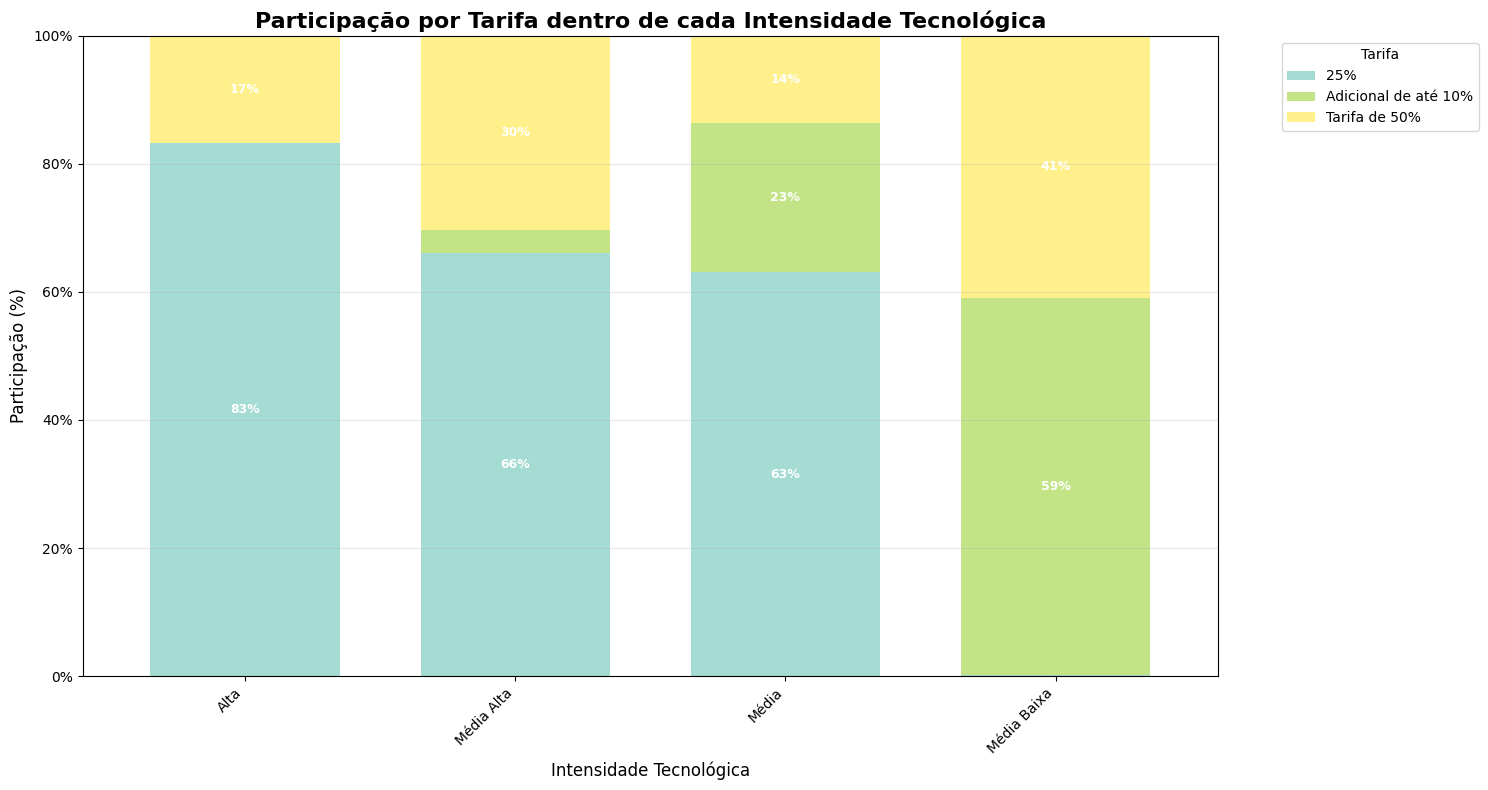


=== Estatísticas da Análise ===
Total de registros: 3222
Total FOB USA: R$ 188,687,566,171

=== Distribuição por Intensidade Tecnológica ===
Média Baixa Intensidade Tecnológica: R$ 75,190,245,236 (39.8%)
Média Intensidade Tecnológica: R$ 54,859,104,049 (29.1%)
Média Alta Intensidade Tecnológica: R$ 43,342,814,224 (23.0%)
Alta Intensidade Tecnológica: R$ 15,295,402,662 (8.1%)

=== Top 10 Tarifas por Valor FOB USA ===
Tarifa 25%: R$ 76,050,388,945 (40.3%)
Tarifa Adicional de até 10%: R$ 58,728,714,538 (31.1%)
Tarifa Tarifa de 50%: R$ 53,908,462,688 (28.6%)

=== SETORES DISPONÍVEIS (primeiros 10) ===
cnae                                               cnae_descricao
 060                           Extração de petróleo e gás natural
 071                                 Extração de minério de ferro
 072                  Extração de minerais metálicos não-ferrosos
 081                            Extração de pedra, areia e argila
 089                    Extração de outros minerais não-metálico

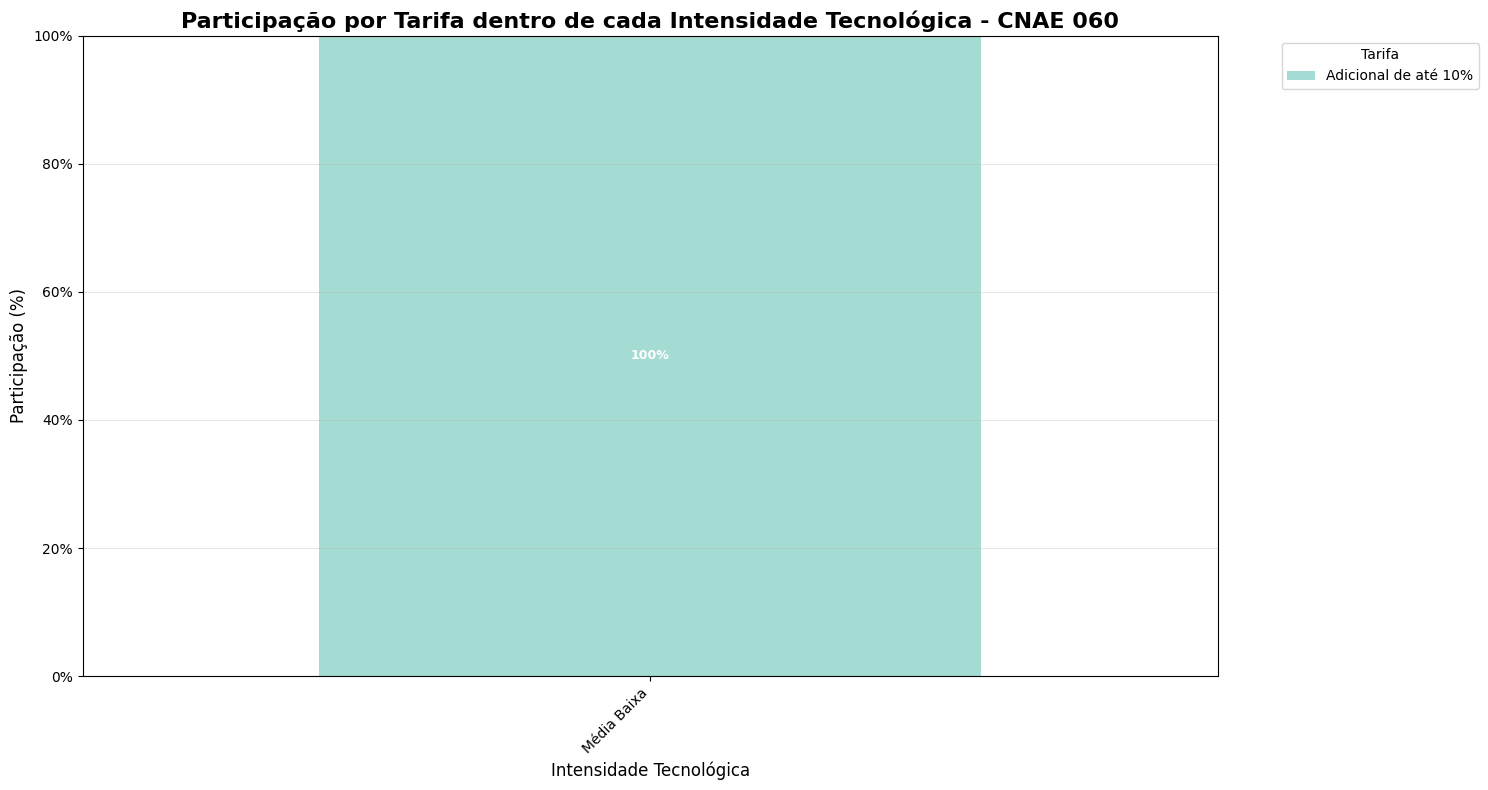


=== Estatísticas da Análise - CNAE 060 ===
Total de registros: 2
Total FOB USA: R$ 25,251,450,022

=== Distribuição por Intensidade Tecnológica ===
Média Baixa Intensidade Tecnológica: R$ 25,251,450,022 (100.0%)

=== Top 10 Tarifas por Valor FOB USA ===
Tarifa Adicional de até 10%: R$ 25,251,450,022 (100.0%)


In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def criar_grafico_intensidade_tarifa(dataframe, cnae_selecionado=None):
    """
    Cria gráfico de barras empilhadas por intensidade tecnológica e tarifa
    
    Args:
        dataframe: DataFrame com as colunas especificadas
        cnae_selecionado: Filtrar por CNAE específico (opcional)
    """
    
    # Filtrar por CNAE se especificado
    if cnae_selecionado:
        dados = dataframe[dataframe['cnae'] == cnae_selecionado].copy()
        titulo_adicional = f' - CNAE {cnae_selecionado}'
    else:
        dados = dataframe.copy()
        titulo_adicional = ''
    
    if dados.empty:
        print(f"Não foram encontrados dados para análise")
        return
    
    # Verificar se as colunas necessárias existem
    colunas_necessarias = ['Intensidade Tecnológica', 'Tarifa', 'R$ FOB USA']
    for col in colunas_necessarias:
        if col not in dados.columns:
            print(f"Coluna '{col}' não encontrada no dataframe")
            return
    
    # Agregar dados por intensidade tecnológica e tarifa
    dados_agrupados = dados.groupby(['Intensidade Tecnológica', 'Tarifa']).agg({
        'R$ FOB USA': 'sum'
    }).reset_index()
    
    # Criar pivot para facilitar o gráfico empilhado
    dados_pivot = dados_agrupados.pivot(index='Intensidade Tecnológica', 
                                       columns='Tarifa', 
                                       values='R$ FOB USA').fillna(0)
    
    # Normalizar para mostrar proporção dentro de cada intensidade
    dados_pivot_norm = dados_pivot.div(dados_pivot.sum(axis=1), axis=0)
    
    # Ordenar intensidades por ordem lógica
    ordem_intensidade = [
        'Alta Intensidade Tecnológica', 
        'Média Alta Intensidade Tecnológica',
        'Média Intensidade Tecnológica', 
        'Média Baixa Intensidade Tecnológica',
        'Baixa Intensidade Tecnológica'
    ]
    
    # Filtrar apenas intensidades que existem nos dados
    intensidades_existentes = [i for i in ordem_intensidade if i in dados_pivot_norm.index]
    dados_pivot_norm = dados_pivot_norm.reindex(intensidades_existentes)
    
    # Configurar o gráfico
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Definir cores para as diferentes tarifas
    n_tarifas = len(dados_pivot.columns)
    cores = plt.cm.Set3(np.linspace(0, 1, n_tarifas))
    
    # Criar gráfico de barras empilhadas
    dados_pivot_norm.plot(kind='bar', 
                         stacked=True, 
                         ax=ax, 
                         color=cores,
                         alpha=0.8,
                         width=0.7)
    
    # Configurações do gráfico
    ax.set_title(f'Participação por Tarifa dentro de cada Intensidade Tecnológica{titulo_adicional}', 
                 fontsize=16, fontweight='bold')
    ax.set_xlabel('Intensidade Tecnológica', fontsize=12)
    ax.set_ylabel('Participação (%)', fontsize=12)
    
    # Simplificar rótulos do eixo X
    labels_simplificados = [label.replace(' Intensidade Tecnológica', '') for label in dados_pivot_norm.index]
    ax.set_xticklabels(labels_simplificados, rotation=45, ha='right')
    
    # Configurar legenda
    ax.legend(title='Tarifa', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    
    # Grid e formatação
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1)
    
    # Formatar eixo Y como percentual
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Adicionar valores percentuais nas barras (apenas para segmentos maiores)
    for i, intensidade in enumerate(dados_pivot_norm.index):
        y_offset = 0
        for j, tarifa in enumerate(dados_pivot_norm.columns):
            valor = dados_pivot_norm.loc[intensidade, tarifa]
            if valor > 0.05:  # Só mostrar se > 5%
                ax.text(i, y_offset + valor/2, f'{valor:.0%}', 
                       ha='center', va='center', fontsize=9, 
                       fontweight='bold', color='white')
            y_offset += valor
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir estatísticas
    print(f"\n=== Estatísticas da Análise{titulo_adicional} ===")
    print(f"Total de registros: {len(dados)}")
    print(f"Total FOB USA: R$ {dados['R$ FOB USA'].sum():,.0f}")
    
    print(f"\n=== Distribuição por Intensidade Tecnológica ===")
    resumo_intensidade = dados.groupby('Intensidade Tecnológica')['R$ FOB USA'].sum().sort_values(ascending=False)
    for intensidade, valor in resumo_intensidade.items():
        participacao = valor / resumo_intensidade.sum()
        print(f"{intensidade}: R$ {valor:,.0f} ({participacao:.1%})")
    
    print(f"\n=== Top 10 Tarifas por Valor FOB USA ===")
    resumo_tarifa = dados.groupby('Tarifa')['R$ FOB USA'].sum().sort_values(ascending=False).head(10)
    for tarifa, valor in resumo_tarifa.items():
        participacao = valor / dados['R$ FOB USA'].sum()
        print(f"Tarifa {tarifa}: R$ {valor:,.0f} ({participacao:.1%})")
    
    return dados_agrupados, dados_pivot_norm

def analisar_setor_especifico(dataframe, cnae_codigo):
    """
    Análise específica para um setor CNAE
    """
    print(f"=== ANÁLISE DETALHADA DO SETOR CNAE {cnae_codigo} ===")
    
    # Verificar se existe o CNAE
    if cnae_codigo not in dataframe['cnae'].values:
        print(f"CNAE {cnae_codigo} não encontrado no dataframe")
        setores_disponiveis = dataframe['cnae'].unique()[:10]
        print(f"Setores disponíveis (primeiros 10): {setores_disponiveis}")
        return None
    
    # Criar gráfico para o setor específico
    dados_agrupados, dados_pivot = criar_grafico_intensidade_tarifa(dataframe, cnae_codigo)
    
    return dados_agrupados, dados_pivot

# Exemplo de uso:
# Assumindo que seu dataframe se chama 'exportacao_pia_tarifas'

# Análise geral (todos os setores)
print("=== ANÁLISE GERAL - TODOS OS SETORES ===")
try:
    # Substitua 'exportacao_pia_tarifas' pelo nome real do seu dataframe
    dados_agrupados_geral, pivot_geral = criar_grafico_intensidade_tarifa(exportacoes_pia_tarifas)
except NameError:
    print("Dataframe não encontrado. Certifique-se de que o dataframe existe com o nome correto.")

# Listar setores disponíveis
try:
    setores_disponiveis = exportacoes_pia_tarifas[['cnae', 'cnae_descricao']].drop_duplicates().sort_values('cnae')
    print(f"\n=== SETORES DISPONÍVEIS (primeiros 10) ===")
    print(setores_disponiveis.head(10).to_string(index=False))
    
    # Análise de um setor específico (exemplo)
    cnae_exemplo = setores_disponiveis['cnae'].iloc[0]
    print(f"\n=== ANÁLISE DO SETOR {cnae_exemplo} ===")
    dados_setor, pivot_setor = analisar_setor_especifico(exportacoes_pia_tarifas, cnae_exemplo)
    
except NameError:
    print("Dataframe não encontrado. Verifique o nome do dataframe.")

Setores disponíveis:
     cnae                      cnae_descricao
2614  060  Extração de petróleo e gás natural
2009  071        Extração de minério de ferro

Analisando setor: 060


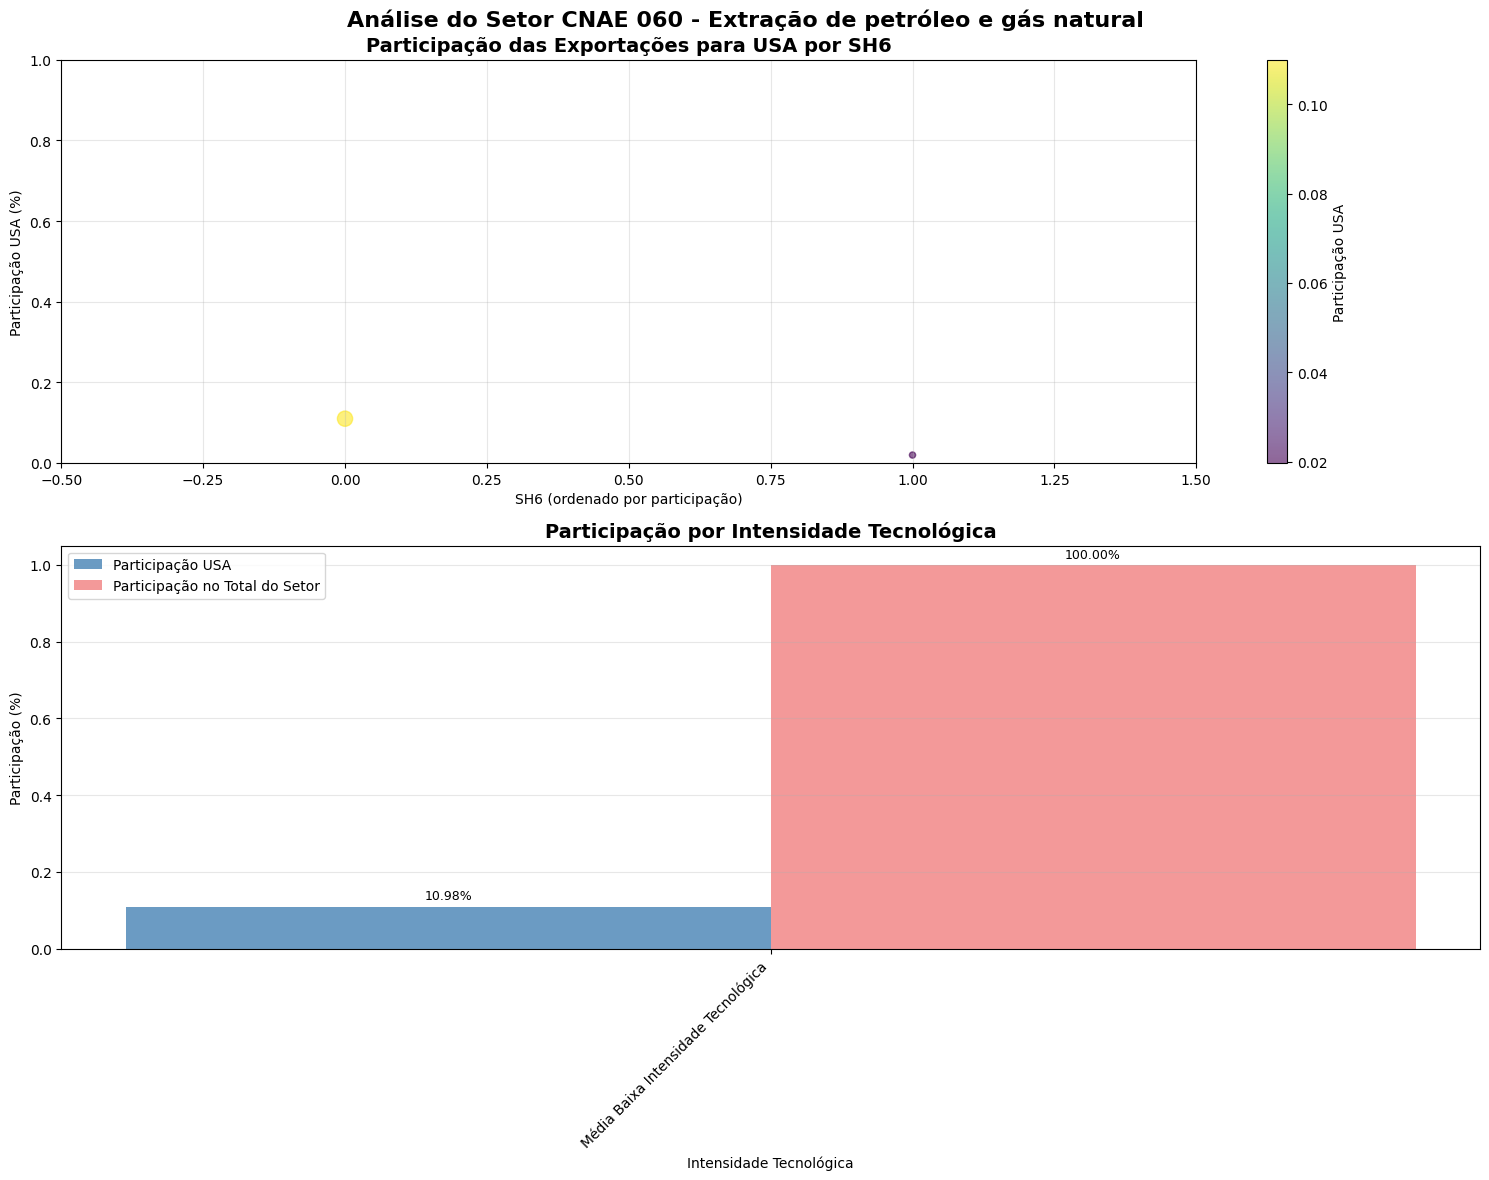


=== Estatísticas do Setor CNAE 060 ===
Descrição: Extração de petróleo e gás natural
Quantidade de SH6s: 2
Exportações Totais para o Mundo: R$ 229,920,398,959
Exportações para USA: R$ 25,251,450,022
Participação USA no setor: 10.98%


In [156]:
# Exemplo de uso:
# Listar setores disponíveis
print("Setores disponíveis:")
setores_disponiveis = exportacoes_pia_tarifas[['cnae', 'cnae_descricao']].drop_duplicates().sort_values('cnae')
print(setores_disponiveis.head(2))

# Selecionar um setor específico (exemplo: primeiro setor disponível)
cnae_exemplo = setores_disponiveis['cnae'].iloc[0]
print(f"\nAnalisando setor: {cnae_exemplo}")

# Criar os gráficos
dados_setor, dados_intensidade = criar_graficos_setor(cnae_exemplo, exportacoes_pia_tarifas)

In [90]:
exportacoes_pia['R$ FOB USA'] = exportacoes_pia['R$ FOB USA'].astype(float)
exportacoes_pia['Total da receita líquida de vendas'] = exportacoes_pia['Total da receita líquida de vendas'].astype(float)

In [120]:
exportacoes_agregadas_cnae = exportacoes_pia.groupby(['cnae','cnae_descricao']).aggregate({'R$ FOB USA': 'sum','Total da receita líquida de vendas' : 'mean' }).reset_index()

In [121]:
exportacoes_agregadas_cnae.head()

,cnae,cnae_descricao,R$ FOB USA,Total da receita líquida de vendas
0,060,Extração de petróleo e gás natural,2.525145e+10,1.632819e+11
1,071,Extração de minério de ferro,2.071770e+09,1.969583e+11
2,072,Extração de minerais metálicos não-ferrosos,3.120151e+07,2.746607e+10
3,081,"Extração de pedra, areia e argila",8.988183e+07,2.500557e+10
4,089,Extração de outros minerais não-metálicos,2.669222e+08,8.940663e+09


In [122]:
exportacoes_agregadas_cnae['participacao_usa'] = exportacoes_agregadas_cnae['R$ FOB USA'] / exportacoes_agregadas_cnae['Total da receita líquida de vendas']

In [124]:
exportacoes_agregadas_cnae.sort_values(by='participacao_usa', ascending=False)

,cnae,cnae_descricao,R$ FOB USA,Total da receita líquida de vendas,participacao_usa
54,304,Fabricação de aeronaves,1.222860e+10,2.113848e+10,5.784995e-01
33,255,"Fabricação de equipamento bélico pesado, armas...",1.734273e+09,3.961277e+09,4.378066e-01
19,161,Desdobramento de madeira,3.889612e+09,1.501246e+10,2.590922e-01
0,060,Extração de petróleo e gás natural,2.525145e+10,1.632819e+11,1.546494e-01
57,321,"Fabricação de artigos de joalheria, bijuteria ...",6.206487e+08,4.194860e+09,1.479546e-01
...,...,...,...,...,...
21,18,Impressão e reprodução de gravações,1.132288e+06,2.286563e+10,4.951921e-05
41,268,"Fabricação de mídias virgens, magnéticas e ópt...",5.432565e+06,-1.000000e+03,-5.432565e+03
40,267,Fabricação de equipamentos e instrumentos ópti...,1.160705e+07,-1.000000e+03,-1.160705e+04
53,303,Fabricação de veículos ferroviários,9.602509e+07,-1.000000e+03,-9.602509e+04


In [118]:
exportacoes_pia.groupby(['cnae','cnae_descricao']).aggregate({'R$ FOB USA': 'sum','Total da receita líquida de vendas' : 'mean' }).reset_index().query('cnae == "060"')

,cnae,cnae_descricao,R$ FOB USA,Total da receita líquida de vendas
0,060,Extração de petróleo e gás natural,2.525145e+10,1.632819e+11
